# Datasets and Dataloaders

In [2]:
# Dataset is a class that stores samples and labels of a dataset
# Dataloader is a class that wraps an iterable around the Dataset

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.FashionMNIST(root="../data",
                                      train=True,
                                      download=True,
                                      transform=ToTensor())

0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
test_data = datasets.FashionMNIST(root="../data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor())

In [7]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

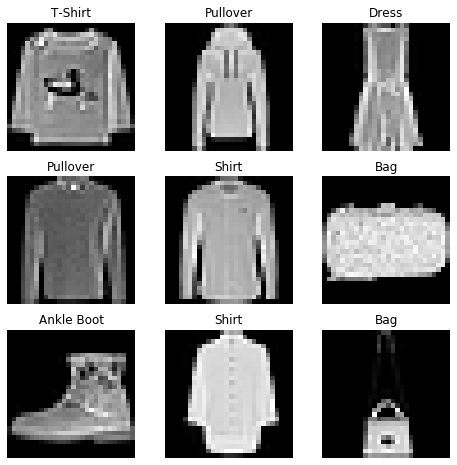

In [13]:
# 9 random samples from the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # Squeeze() removes dims of size 1 from tensor
plt.show()

In [16]:
# Creating a custom dataset: Custom implementations of Dataset must implement three functions:
# __init__, __len__, and __getitem__

import os
import pandas as pd
from torchvision.io import read_image

# Assume annotations file is in format "{image_name}, {label}", e.g.
# image000.jpg, 0
# image001.jpg, 0
# ...
# image998.jpg, 9
# image999.jpg, 9

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """Initialize directory of image files and annotations file."""
        # Get image labels
        self.img_labels = pd.read_csv(annotations_file)
        # Initialize image directory
        self.img_dir = img_dir
        # Set transforms (covered in next section)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Return number of samples in dataset"""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Load and return a sample from the dataset at the given index idx."""
        # Get the image name from the annotations dataframe
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # Read the image using torchvision's read_image function
        image = read_image(img_path)
        # Get the label from the annotations dataframe
        label = self.img_labels.iloc[idx, 1]
        # Transform if applicable
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # Return sample image and label as a dict
        sample = {"image": image, "label": label}
        return sample

In [17]:
# Prepare data for training with DataLoaders:
from torch.utils.data import DataLoader

In [18]:
# Prepare dataset into randomized minibatches of size 64, speed up retrieval using Python's multiprocessing:
# Dataloader abstracts this away.
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [19]:
# Iterate through the dataset: get batch of 64 features and labels
train_features, train_labels = next(iter(train_dataloader))

In [30]:
# Random minibatch of 64 images of shape 28x28
train_features.shape 

torch.Size([64, 1, 28, 28])

In [31]:
# ...and their associated 64 labels
train_labels.shape

torch.Size([64])

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


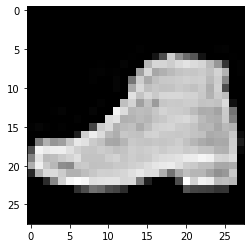

Label: 9
Label category: Ankle Boot


In [32]:
# Show image of first item in batch
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(f"Label category: {labels_map[label.item()]}")

In [33]:
# Transforms can, well, transform the data.
# All TorchVision datasets have two parameters: transform (for the features) and target_transform (for the labels)
# The module torchvision.transforms offers several common transforms out of the box.
# E.g. The FashionMNIST features are in PIL format and the labels are integers, but for training we need the features
# as normalized tensors, and the labels as one-hot encoded tensors.

In [34]:
# The lambda transformation can be any user-defined lambda function, but here we convert integers into one-hot encoded
# tensor. First create a zero tensor of size n_labels, then call scatter_ which assigns a value=1 on the index y (given
# by the label)

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!
